# Fingerprint-based similarity scores - switch to sparse scores!

## Challenge
Fixed-length fingerprints come with problem of bit collisions. This can be circumvented when using sparse vectors.

## Data

Here we use the **ms2structures dataset** containing 37,811 unique compounds.

In [ ]:
import os
import sys
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random

from tqdm.notebook import tqdm

from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem
from rdkit.Chem import Draw

ROOT = Path(os.getcwd()).parents[0]

path_data = os.path.join(Path(ROOT), "data")

In [2]:
filename = "compounds_ms2structures.csv"
compounds = pd.read_csv(os.path.join(path_data, filename))
compounds.head()

,inchikey,smiles,mass,cf_class,cf_subclass,cf_superclass,formula,npc_class_results,npc_pathway_results,npc_superclass_results
0,AAAQFGUYHFJNHI,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...,423.146204,Benzodiazepines,"1,4-benzodiazepines",Organoheterocyclic compounds,C22H22ClN5O2,NaN,Alkaloids,NaN
1,AABFWJDLCCDJJN,COC1=CC2=C(C=C1)NC3=C2C=CN=C3C4=CC=CC5=CC=CC=C54,324.126264,Harmala alkaloids,NaN,Alkaloids and derivatives,C22H16N2O,Carboline alkaloids,Alkaloids,Tryptophan alkaloids
2,AABILZKQMVKFHP,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,427.220624,NaN,NaN,Alkaloids and derivatives,C21H33NO8,Pyrrolizidine alkaloids,Alkaloids,Ornithine alkaloids
3,AABUHSBGEIUSRJ,CC(=O)NC1=CC=C(C=C1)NC(=O)C=CC2=CC=CC=C2,280.120724,Cinnamic acids and derivatives,Cinnamic acid amides,Phenylpropanoids and polyketides,C17H16N2O2,Cinnamic acid amides,Shikimates and Phenylpropanoids,Phenylpropanoids (C6-C3)
4,AABUKWVVUWBZCS,C1=CC=C(C=C1)C2=C(C(=O)OC3=C2C=CC(=C3)O)C4=CC=...,314.094724,Neoflavonoids,Neoflavones,Phenylpropanoids and polyketides,C21H14O3,Neoflavonoids,Shikimates and Phenylpropanoids,Flavonoids


In [3]:
compounds.shape

(37811, 10)

In [ ]:
# Add source code path
sys.path.insert(0, os.path.join(ROOT, "src"))

# Import funtion/classes from source code
from fingerprint_computation import compute_fingerprints_from_smiles
from metrics import generalized_tanimoto_similarity_matrix_sparse, jaccard_similarity_matrix_sparse
from metrics import generalized_tanimoto_similarity_matrix, jaccard_similarity_matrix

In [29]:
from typing import List
from rdkit.Chem import Mol, MolFromSmiles
from map4 import MAP4

def compute_map_fingerprints_from_smiles(smiles, map_generator):
    
    molecules: List[Mol] = [MolFromSmiles(s) for s in smiles]
    fingerprints_map: np.ndarray = map_generator.calculate_many(
        molecules,
        number_of_threads=32,
        verbose=True,
    )
    return list(fingerprints_map)


def compute_sparse_map_fingerprints_from_smiles(
    smiles,
    map_generator,
    count=False,
    ):
    molecules: List[Mol] = [MolFromSmiles(s) for s in smiles]
    fingerprints_map: np.ndarray = map_generator.calculate_many_sparse(
        molecules,
        number_of_threads=32,
        verbose=True,
        count=count,
    )
    return list(fingerprints_map)


def compute_sparse_map_fingerprints_from_smiles_serial(
        smiles,
        map_generator
        ):

    molecules: List[Mol] = [MolFromSmiles(s) for s in smiles]
    fingerprints = []
    for mol in tqdm(molecules):
        fp_bits = map_generator._calculate(mol)
        fingerprints.append(np.sort(map_generator.encoder.hash(fp_bits)))
    return fingerprints

## Compute similarities for dense vs. sparse fingerprint implementations

### Morgan-3 count

In [5]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096)

fingerprints_morgan3 = compute_fingerprints_from_smiles(
    compounds.smiles, 
    fpgen,
    count=True,
    sparse=False,
    progress_bar=True
)

fingerprints_morgan3_sparse = compute_fingerprints_from_smiles(
    compounds.smiles, 
    fpgen,
    count=True,
    sparse=True,
    progress_bar=True
)

100%|███████████████████████████████████| 37811/37811 [00:05<00:00, 6710.08it/s]


In [6]:
%%time

similarities_morgan3_count = generalized_tanimoto_similarity_matrix(
    fingerprints_morgan3, fingerprints_morgan3)

CPU times: user 1h 9min 53s, sys: 8.69 s, total: 1h 10min 1s
Wall time: 2min 28s


In [7]:
%%time

similarities_morgan3_count_sparse = generalized_tanimoto_similarity_matrix_sparse(
    fingerprints_morgan3_sparse, fingerprints_morgan3_sparse)

CPU times: user 11min 17s, sys: 5.05 s, total: 11min 23s
Wall time: 33.9 s


In [8]:
from visualizations import heatmap_comparison

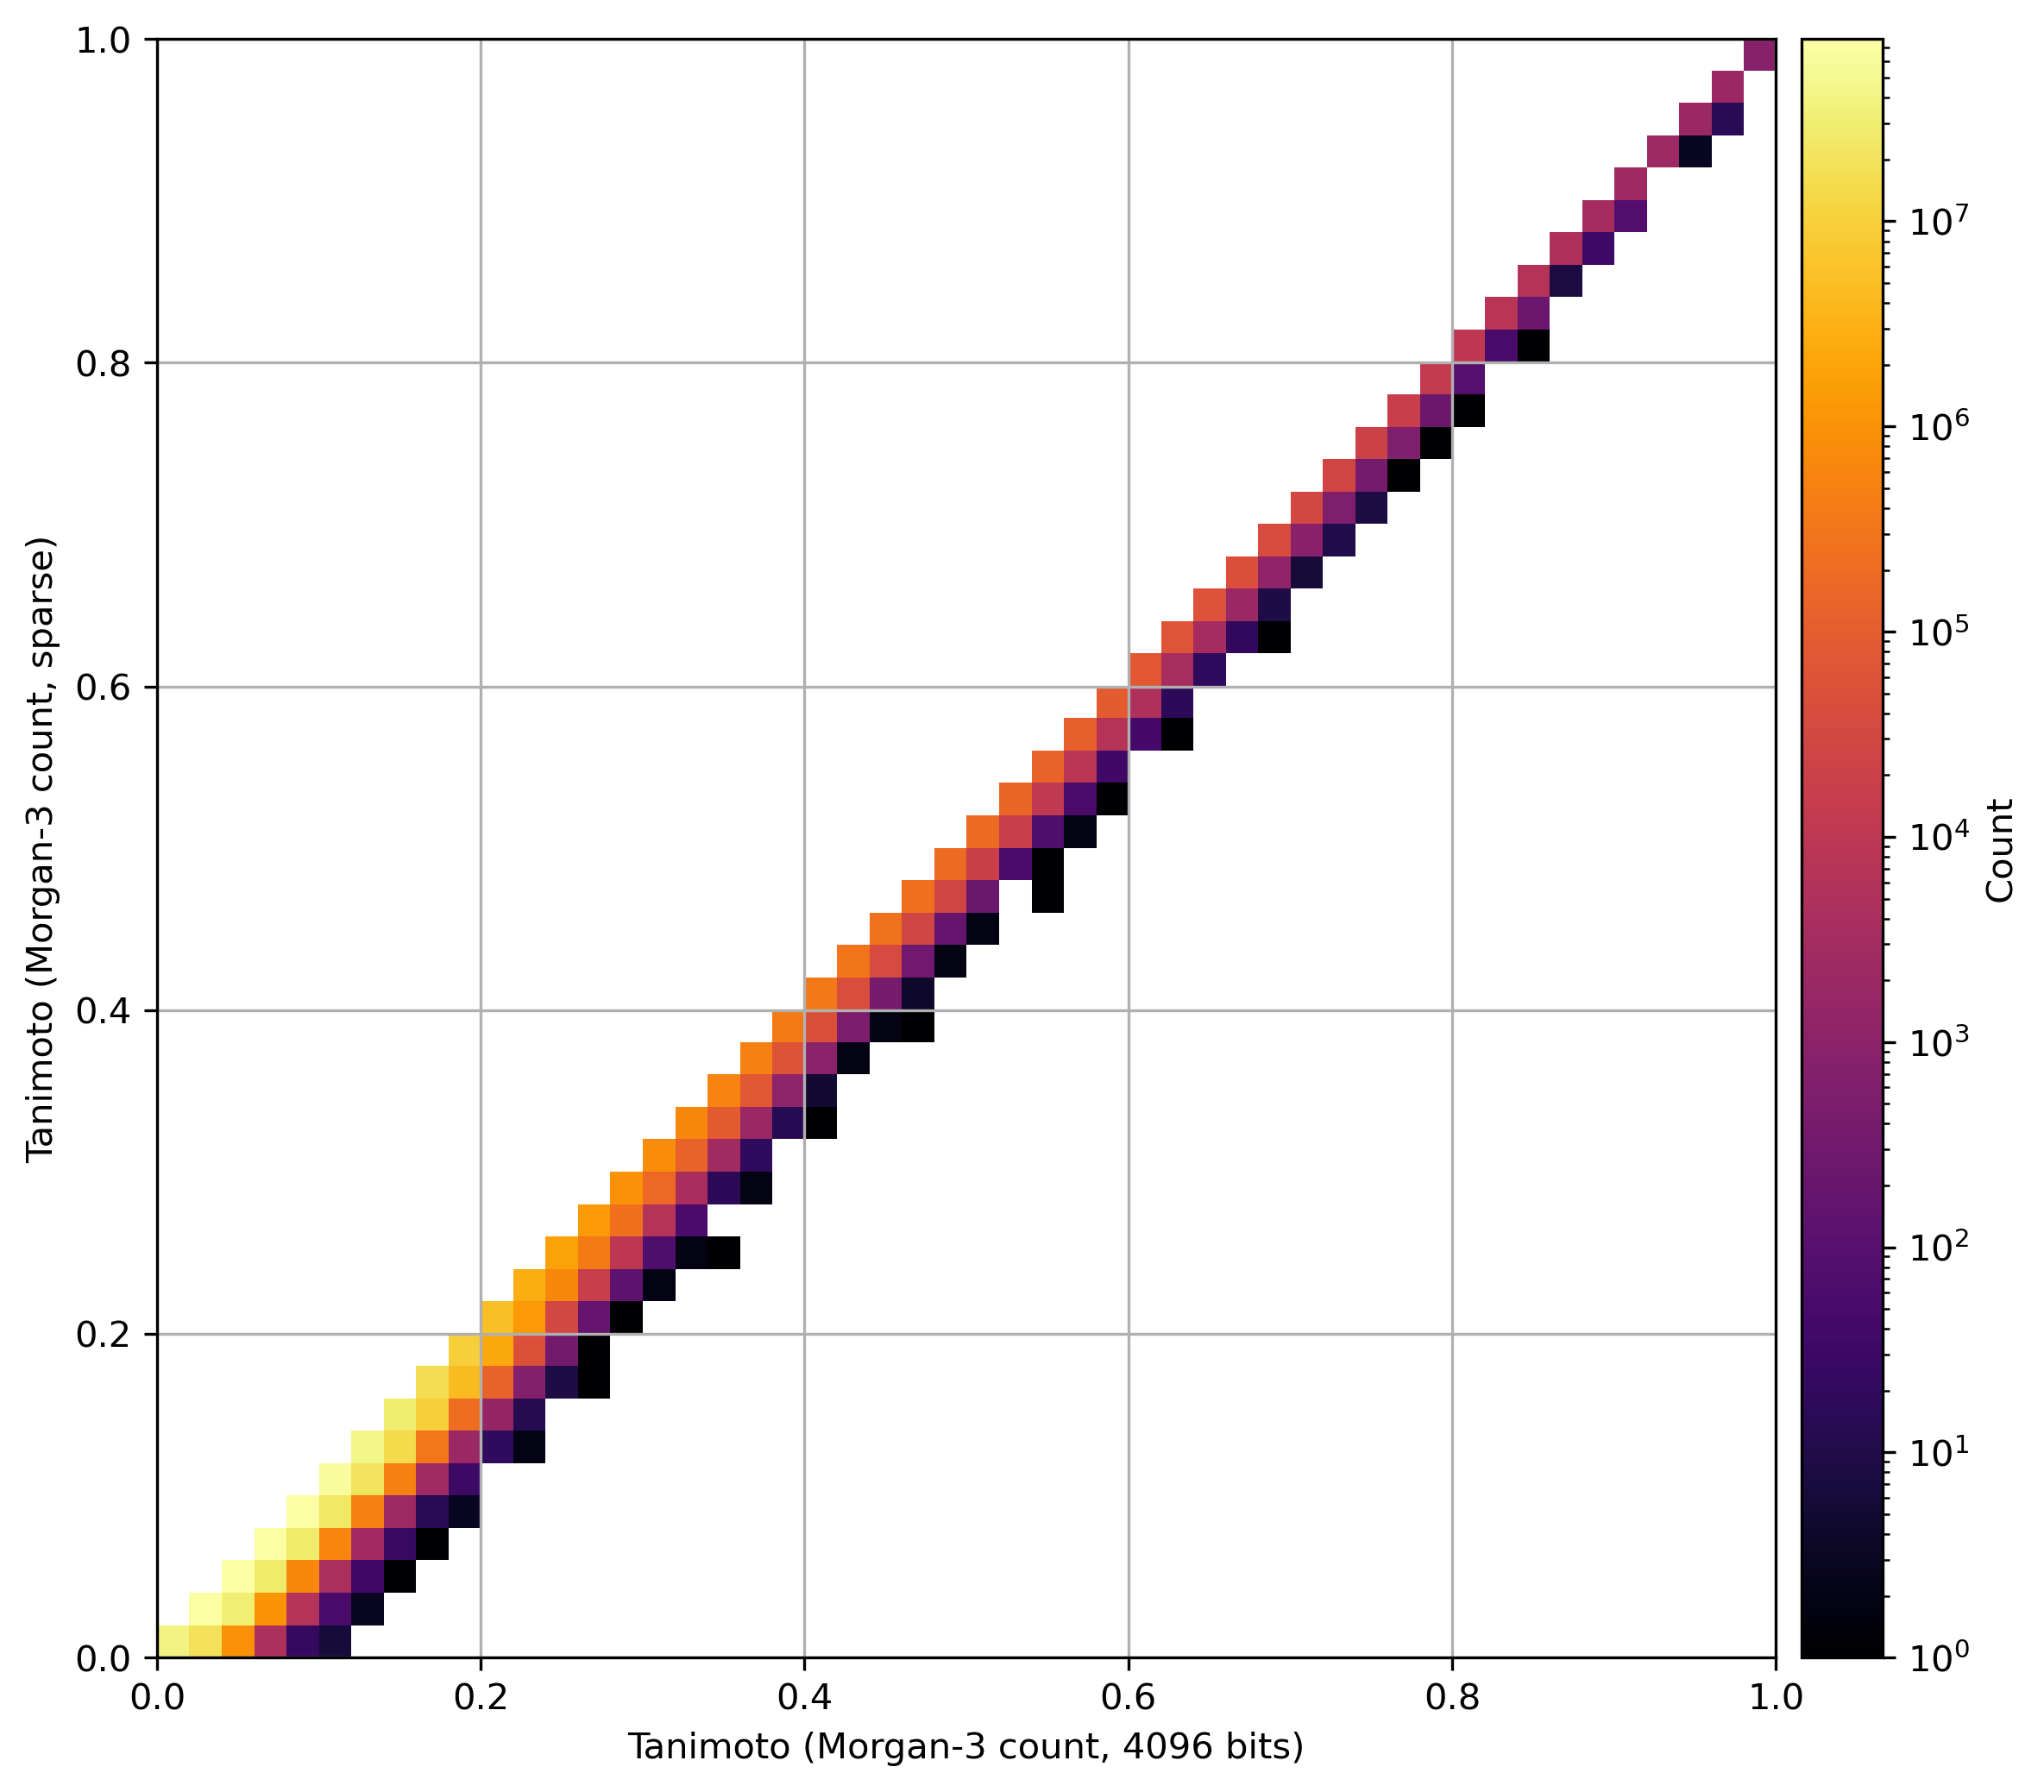

In [ ]:
NBITS = 4096

heatmap_comparison(
    similarities_morgan3_count,
    similarities_morgan3_count_sparse,
    f"Tanimoto (Morgan-3 count, {NBITS} bits)",
    "Tanimoto (Morgan-3 count, sparse)",
    bins=50,
    #colormap="inferno",
    add_region_percentage=False,
    filename="heatmap_morgan3_count_vs_count_sparse.png",
    dpi=450
)

### Rdkit fingerprint

In [23]:
fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=4096)

fingerprints_rdkit = compute_fingerprints_from_smiles(
    compounds.smiles, 
    fpgen,
    count=False,
    sparse=False,
    progress_bar=True
)

fingerprints_rdkit_sparse = compute_fingerprints_from_smiles(
    compounds.smiles, 
    fpgen,
    count=False,
    sparse=True,
    progress_bar=True
)

100%|████████████████████████████████████| 37811/37811 [00:39<00:00, 947.32it/s]


In [24]:
fingerprints_rdkit_sparse[0]

array([   2728909,    7648865,    7746640, ..., 4281855361, 4294389836,
       4294558796])

In [25]:
%%time

similarities_rdkit = jaccard_similarity_matrix(
    fingerprints_rdkit, fingerprints_rdkit
)

CPU times: user 3min 45s, sys: 1min 16s, total: 5min 2s
Wall time: 14.7 s


In [26]:
%%time

similarities_rdkit_sparse = jaccard_similarity_matrix_sparse(
    fingerprints_rdkit_sparse, fingerprints_rdkit_sparse
)

CPU times: user 2h 56min 11s, sys: 9.51 s, total: 2h 56min 20s
Wall time: 6min 5s


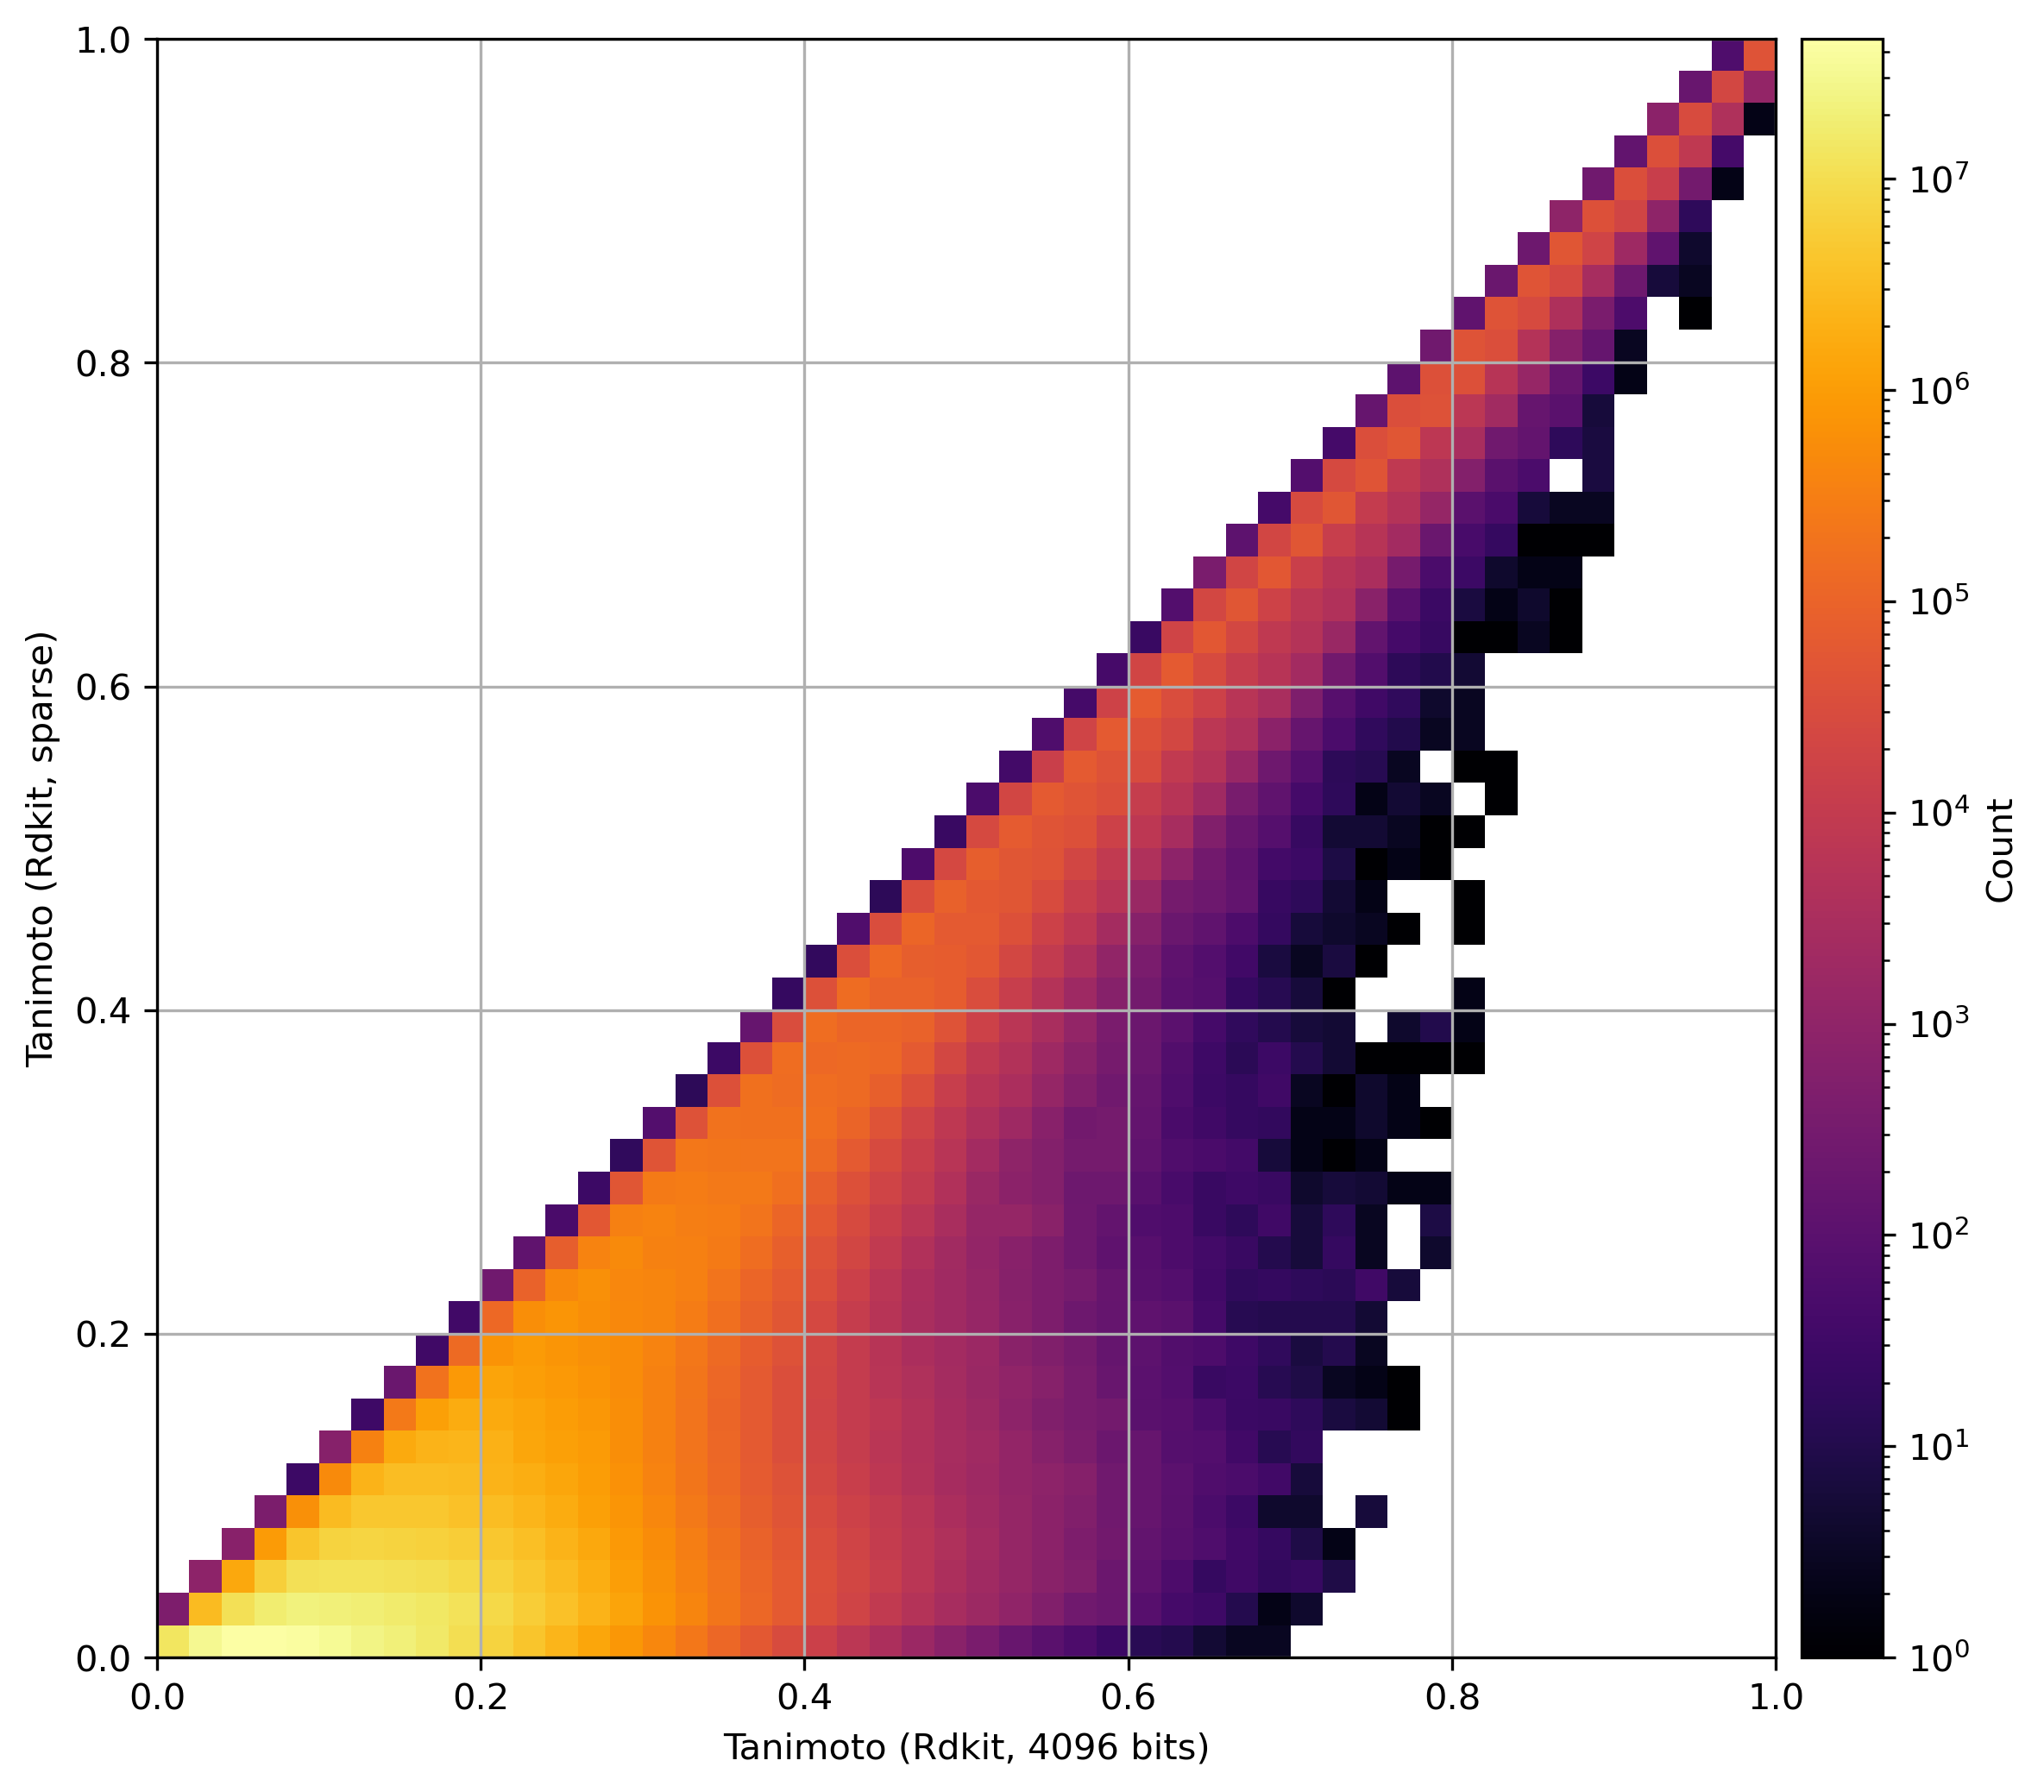

In [ ]:
NBITS = 4096

heatmap_comparison(
    similarities_rdkit,
    similarities_rdkit_sparse,
    f"Tanimoto (Rdkit, {NBITS} bits)",
    "Tanimoto (Rdkit, sparse)",
    bins=50,
    #colormap="inferno",
    add_region_percentage=False,
    filename="heatmap_tanimoto_rdkit_vs_sparse.png",
    dpi=450
)

### MAP4 fingerprint

In [ ]:
map4gen = MAP4(
    dimensions=4096,
    radius=2,
    include_duplicated_shingles=False,
)

fingerprints_map4 = compute_map_fingerprints_from_smiles(compounds.smiles, map4gen)
fingerprints_map4_sparse = compute_sparse_map_fingerprints_from_smiles_serial(compounds.smiles, map4gen)

Calculating fingerprints:   0%|                       | 0/37811 [00:00<?, ?it/s]

  0%|          | 0/37811 [00:00<?, ?it/s]

In [33]:
fingerprints_map4_sparse[0][:20]

array([  2587011,   7175939,  10574304,  14414043,  21442446,  25194880,
        27843837,  45439975,  62152891,  73933071,  73941238,  85932844,
        91228958,  95673192, 105183745, 106192424, 110416896, 112678360,
       113559651, 121484886])

In [34]:
%%time

similarities_map4 = jaccard_similarity_matrix(
    fingerprints_map4, fingerprints_map4
)

CPU times: user 4min 1s, sys: 1min 16s, total: 5min 18s
Wall time: 15.4 s


In [35]:
%%time

similarities_map4_sparse = jaccard_similarity_matrix_sparse(
    fingerprints_map4_sparse, fingerprints_map4_sparse
)

CPU times: user 1h 57min 2s, sys: 8.59 s, total: 1h 57min 11s
Wall time: 4min 6s


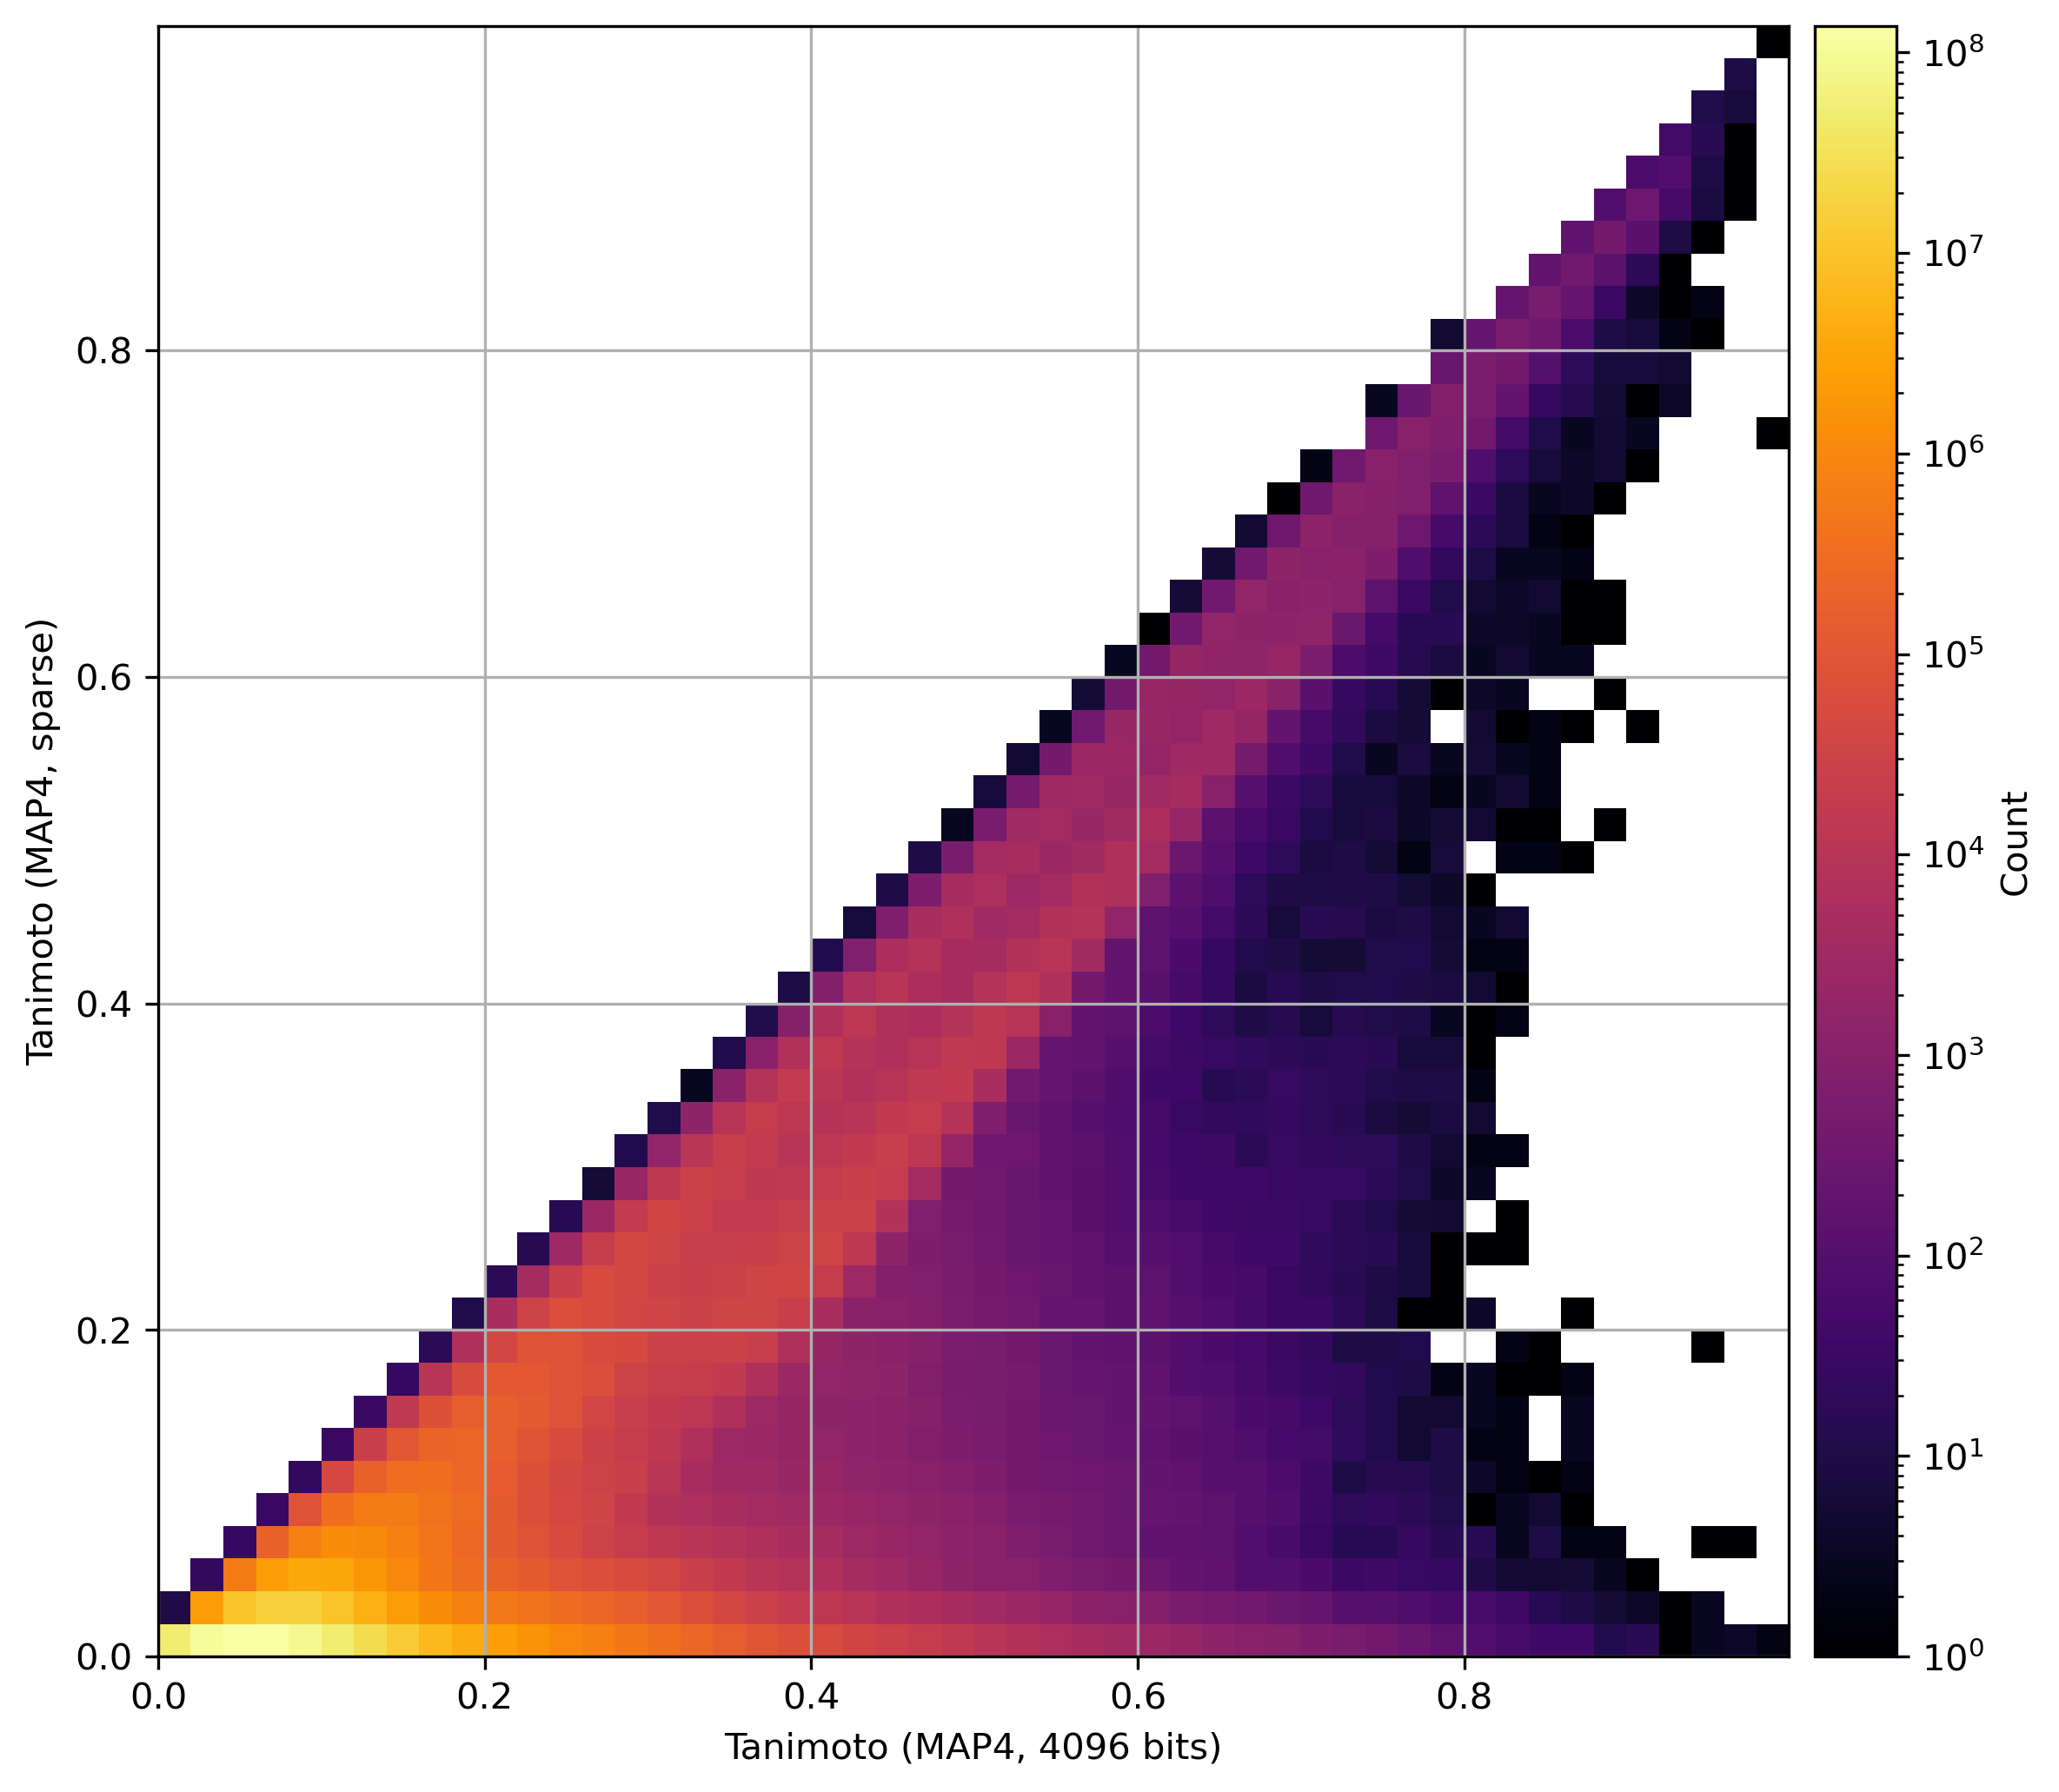

In [ ]:
NBITS = 4096

heatmap_comparison(
    similarities_map4,
    similarities_map4_sparse,
    f"Tanimoto (MAP4, {NBITS} bits)",
    "Tanimoto (MAP4, sparse)",
    bins=50,
    #colormap="inferno",
    add_region_percentage=False,
    filename="heatmap_tanimoto_map4_vs_sparse.png",
    dpi=450
)

# Find example pairs for illustration

In [ ]:
def select_pairs_from_ids(idx, n_pairs=10):
    pairs = list(zip(idx[0], idx[1]))
    
    # Step 1: Sort each pair so that (smaller, larger)
    sorted_pairs = {(min(a, b), max(a, b)) for a, b in pairs}
    
    # Step 2: Convert to a sorted list of unique pairs
    unique_pairs = list(sorted_pairs)
    
    # Step 3: Select only one per first ID
    selected_pairs = {}
    for a, b in unique_pairs:
        if a not in selected_pairs:
            selected_pairs[a] = (a, b)
        else:
            # Randomly decide whether to replace existing pair
            if random.random() > 0.5:
                selected_pairs[a] = (a, b)
    
    # Convert dictionary values back to a list
    final_pairs = list(selected_pairs.values())
    if len(final_pairs) < n_pairs:
        n_pairs = len(final_pairs)
    select_ids = np.random.choice(np.arange(len(final_pairs)), n_pairs, replace=False)
    return [final_pairs[i] for i in select_ids]


def show_pairs_in_grid(
    unique_pairs, ncols=2, figsize=(30, 18),
    filename=None,
    dpi=300,
):
    nrows = -(-len(unique_pairs) // ncols)  # Ceiling division to get number of rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()  # Flatten to iterate easily

    for i, pair in enumerate(unique_pairs):
        id1, id2 = pair
        ax = axes[i]
        
        # Get SMILES and render molecules
        smiles1 = compounds.smiles[id1]
        smiles2 = compounds.smiles[id2]
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
        img = Draw.MolsToGridImage([mol1, mol2], molsPerRow=2, subImgSize=(1000, 1000), returnPNG=False)
        
        ax.imshow(img)
        ax.axis('off')
        
        # Get and display score summary below the molecules
        scores = get_score_summary(id1, id2)
        ax.set_title(f"Pair {i + 1}")
        ax.text(0.5, 0, scores, #.to_string(header=False), 
                transform=ax.transAxes, ha='center', fontsize=10, family='monospace')
    
    # Hide any unused subplots if number of pairs is less than grid size
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, dpi=dpi)
    plt.show()


## Find examples to illustrate regions - RDKIT (sparse vs dense)

In [79]:
def get_score_summary(id1, id2):
    output = f"Tanimoto (RDKIT binary, sparse): {similarities_rdkit_sparse[id1, id2]:.4f}\n" \
    + f"Tanimoto (RDKIT binary, 4096 bit): {similarities_rdkit[id1, id2]:.4f})"
    return output

In [75]:
idx = np.where((similarities_rdkit > 0.7) \
               & (similarities_rdkit_sparse < 0.2) \
              )
idx[0].shape

(294,)

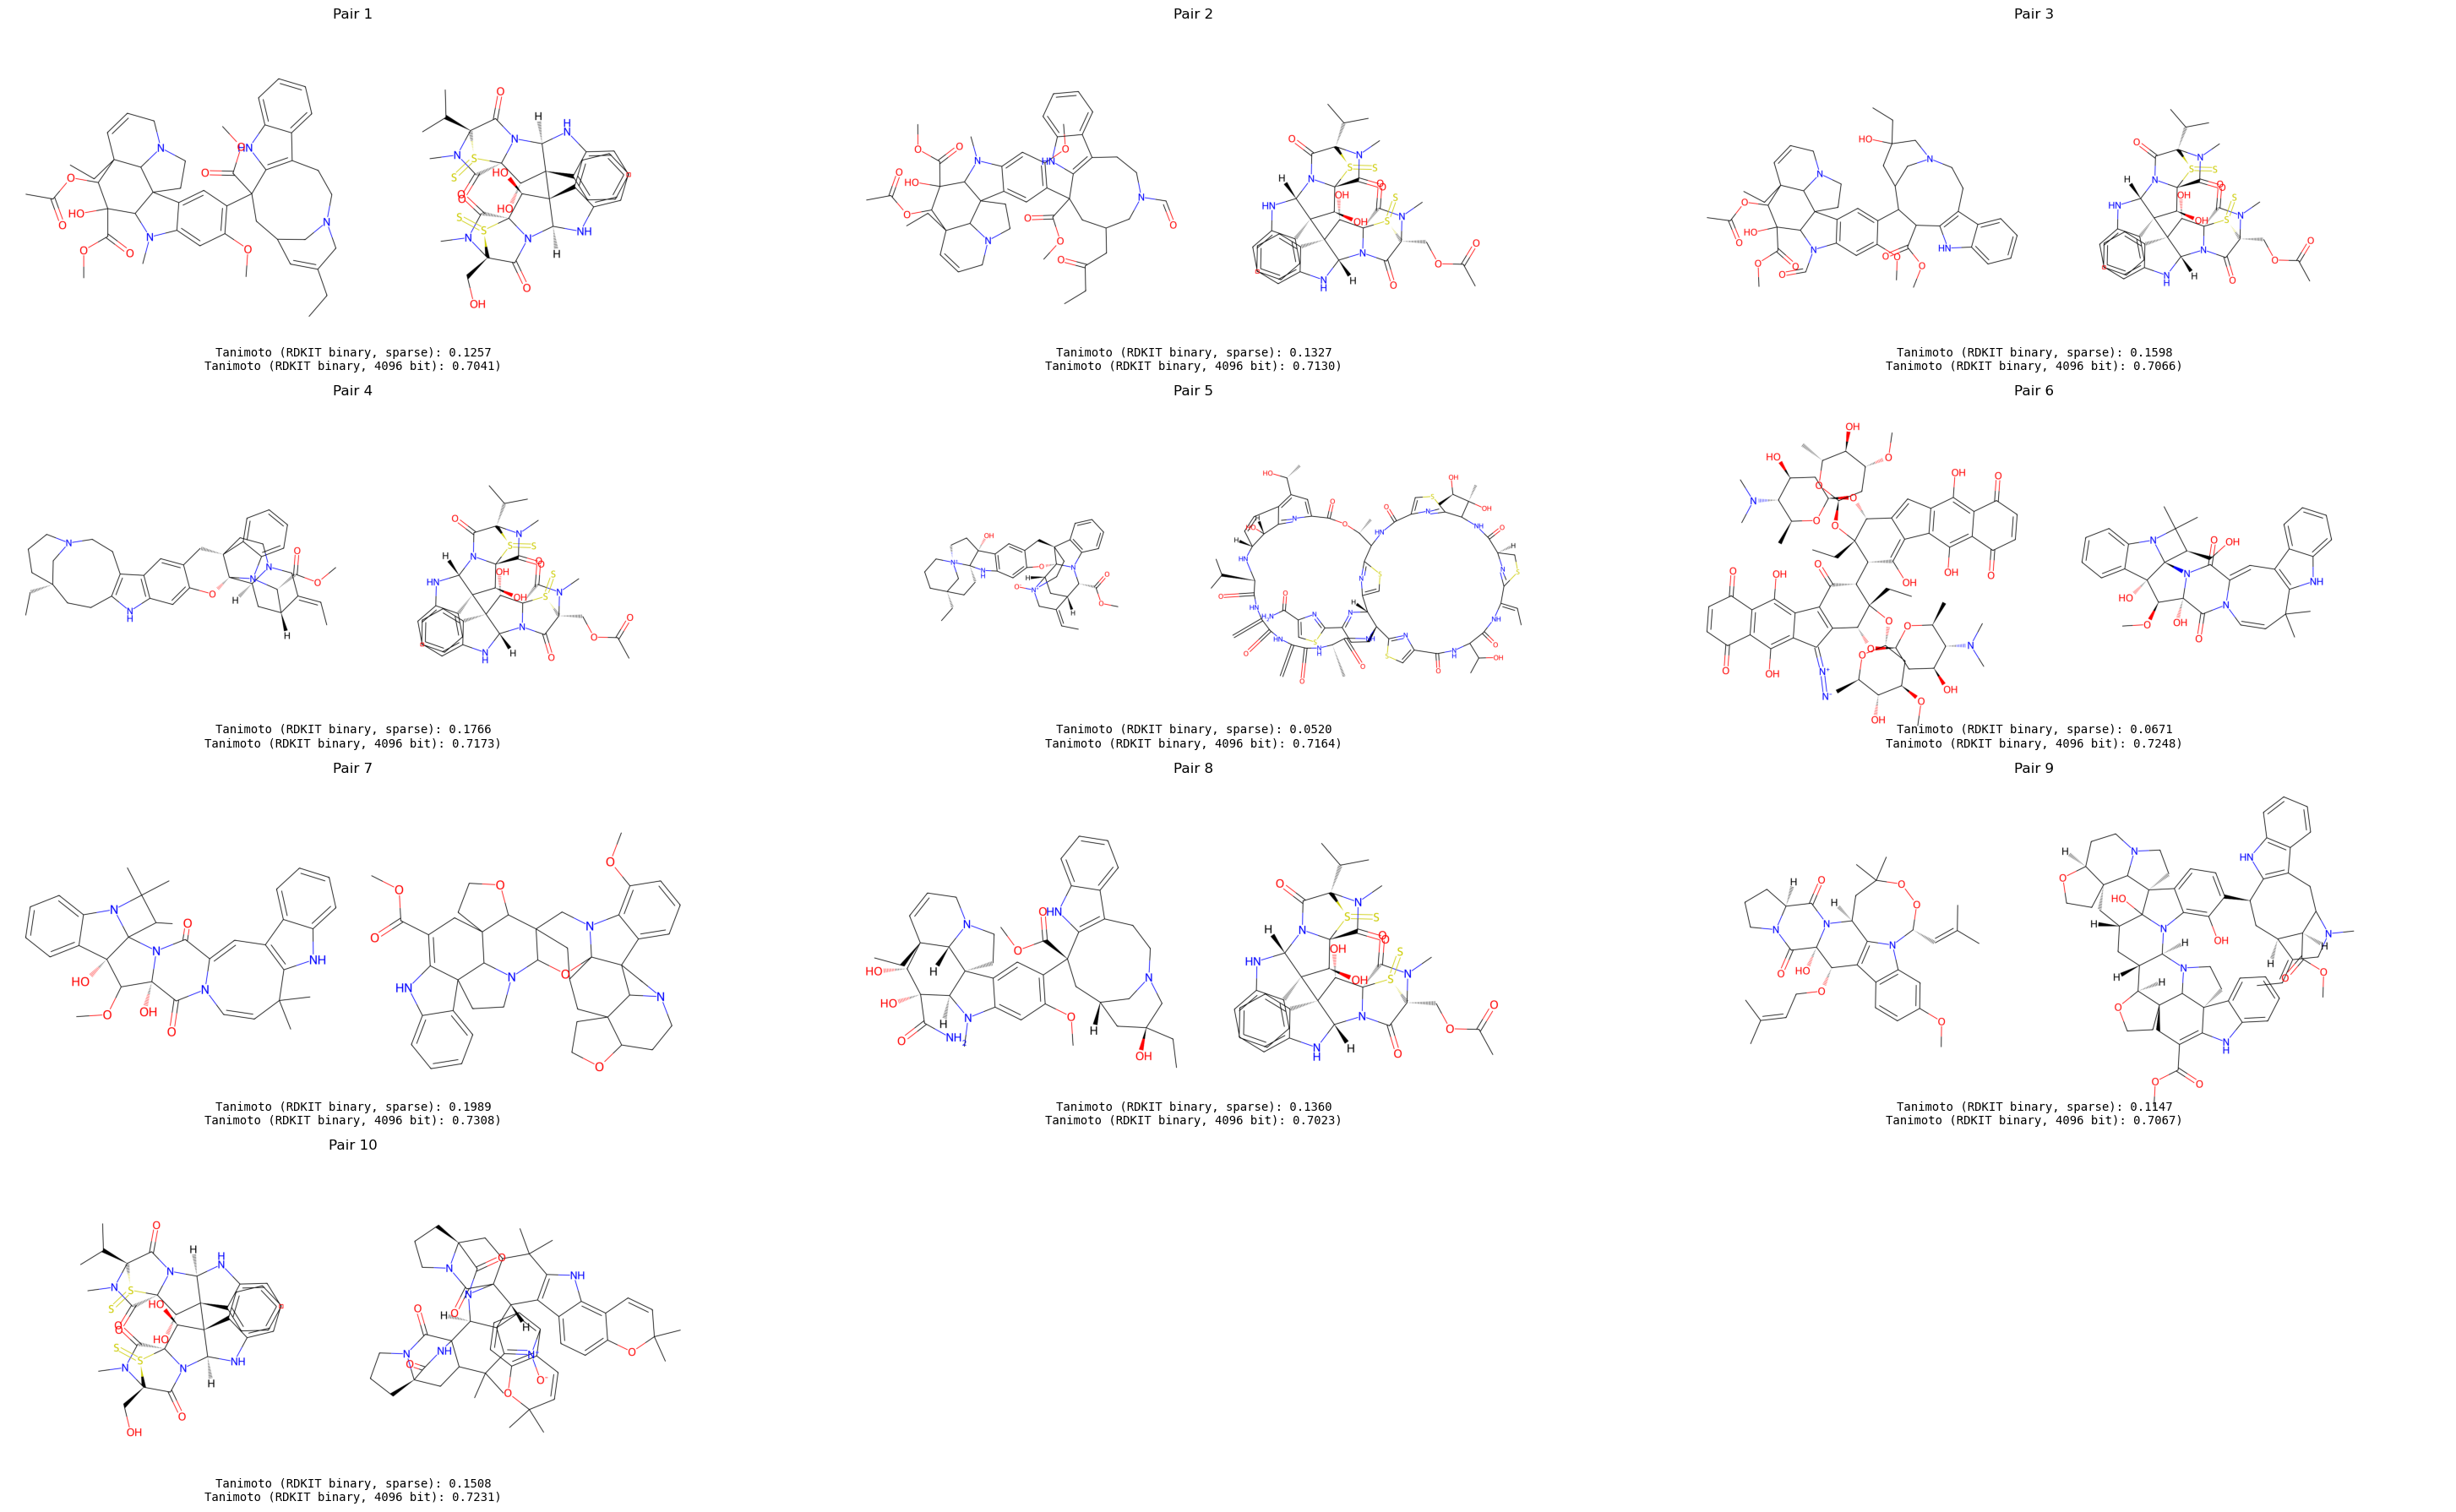

In [80]:
show_pairs_in_grid(select_pairs_from_ids(idx, 10), 3,
                   filename="examples_rdkit_vs_sparse_01.png",
                   dpi=450
                  )

## MAP4 sparse vs dense

In [81]:
def get_score_summary(id1, id2):
    output = f"Tanimoto (MAP4, sparse): {similarities_map4_sparse[id1, id2]:.4f} \n"\
    + f"Tanimoto (MAP4, 4096 bit): {similarities_map4[id1, id2]:.4f}"
    return output

In [82]:
idx = np.where((similarities_map4 > 0.8) \
               & (similarities_map4_sparse < 0.1) \
              )
idx[0].shape

(938,)

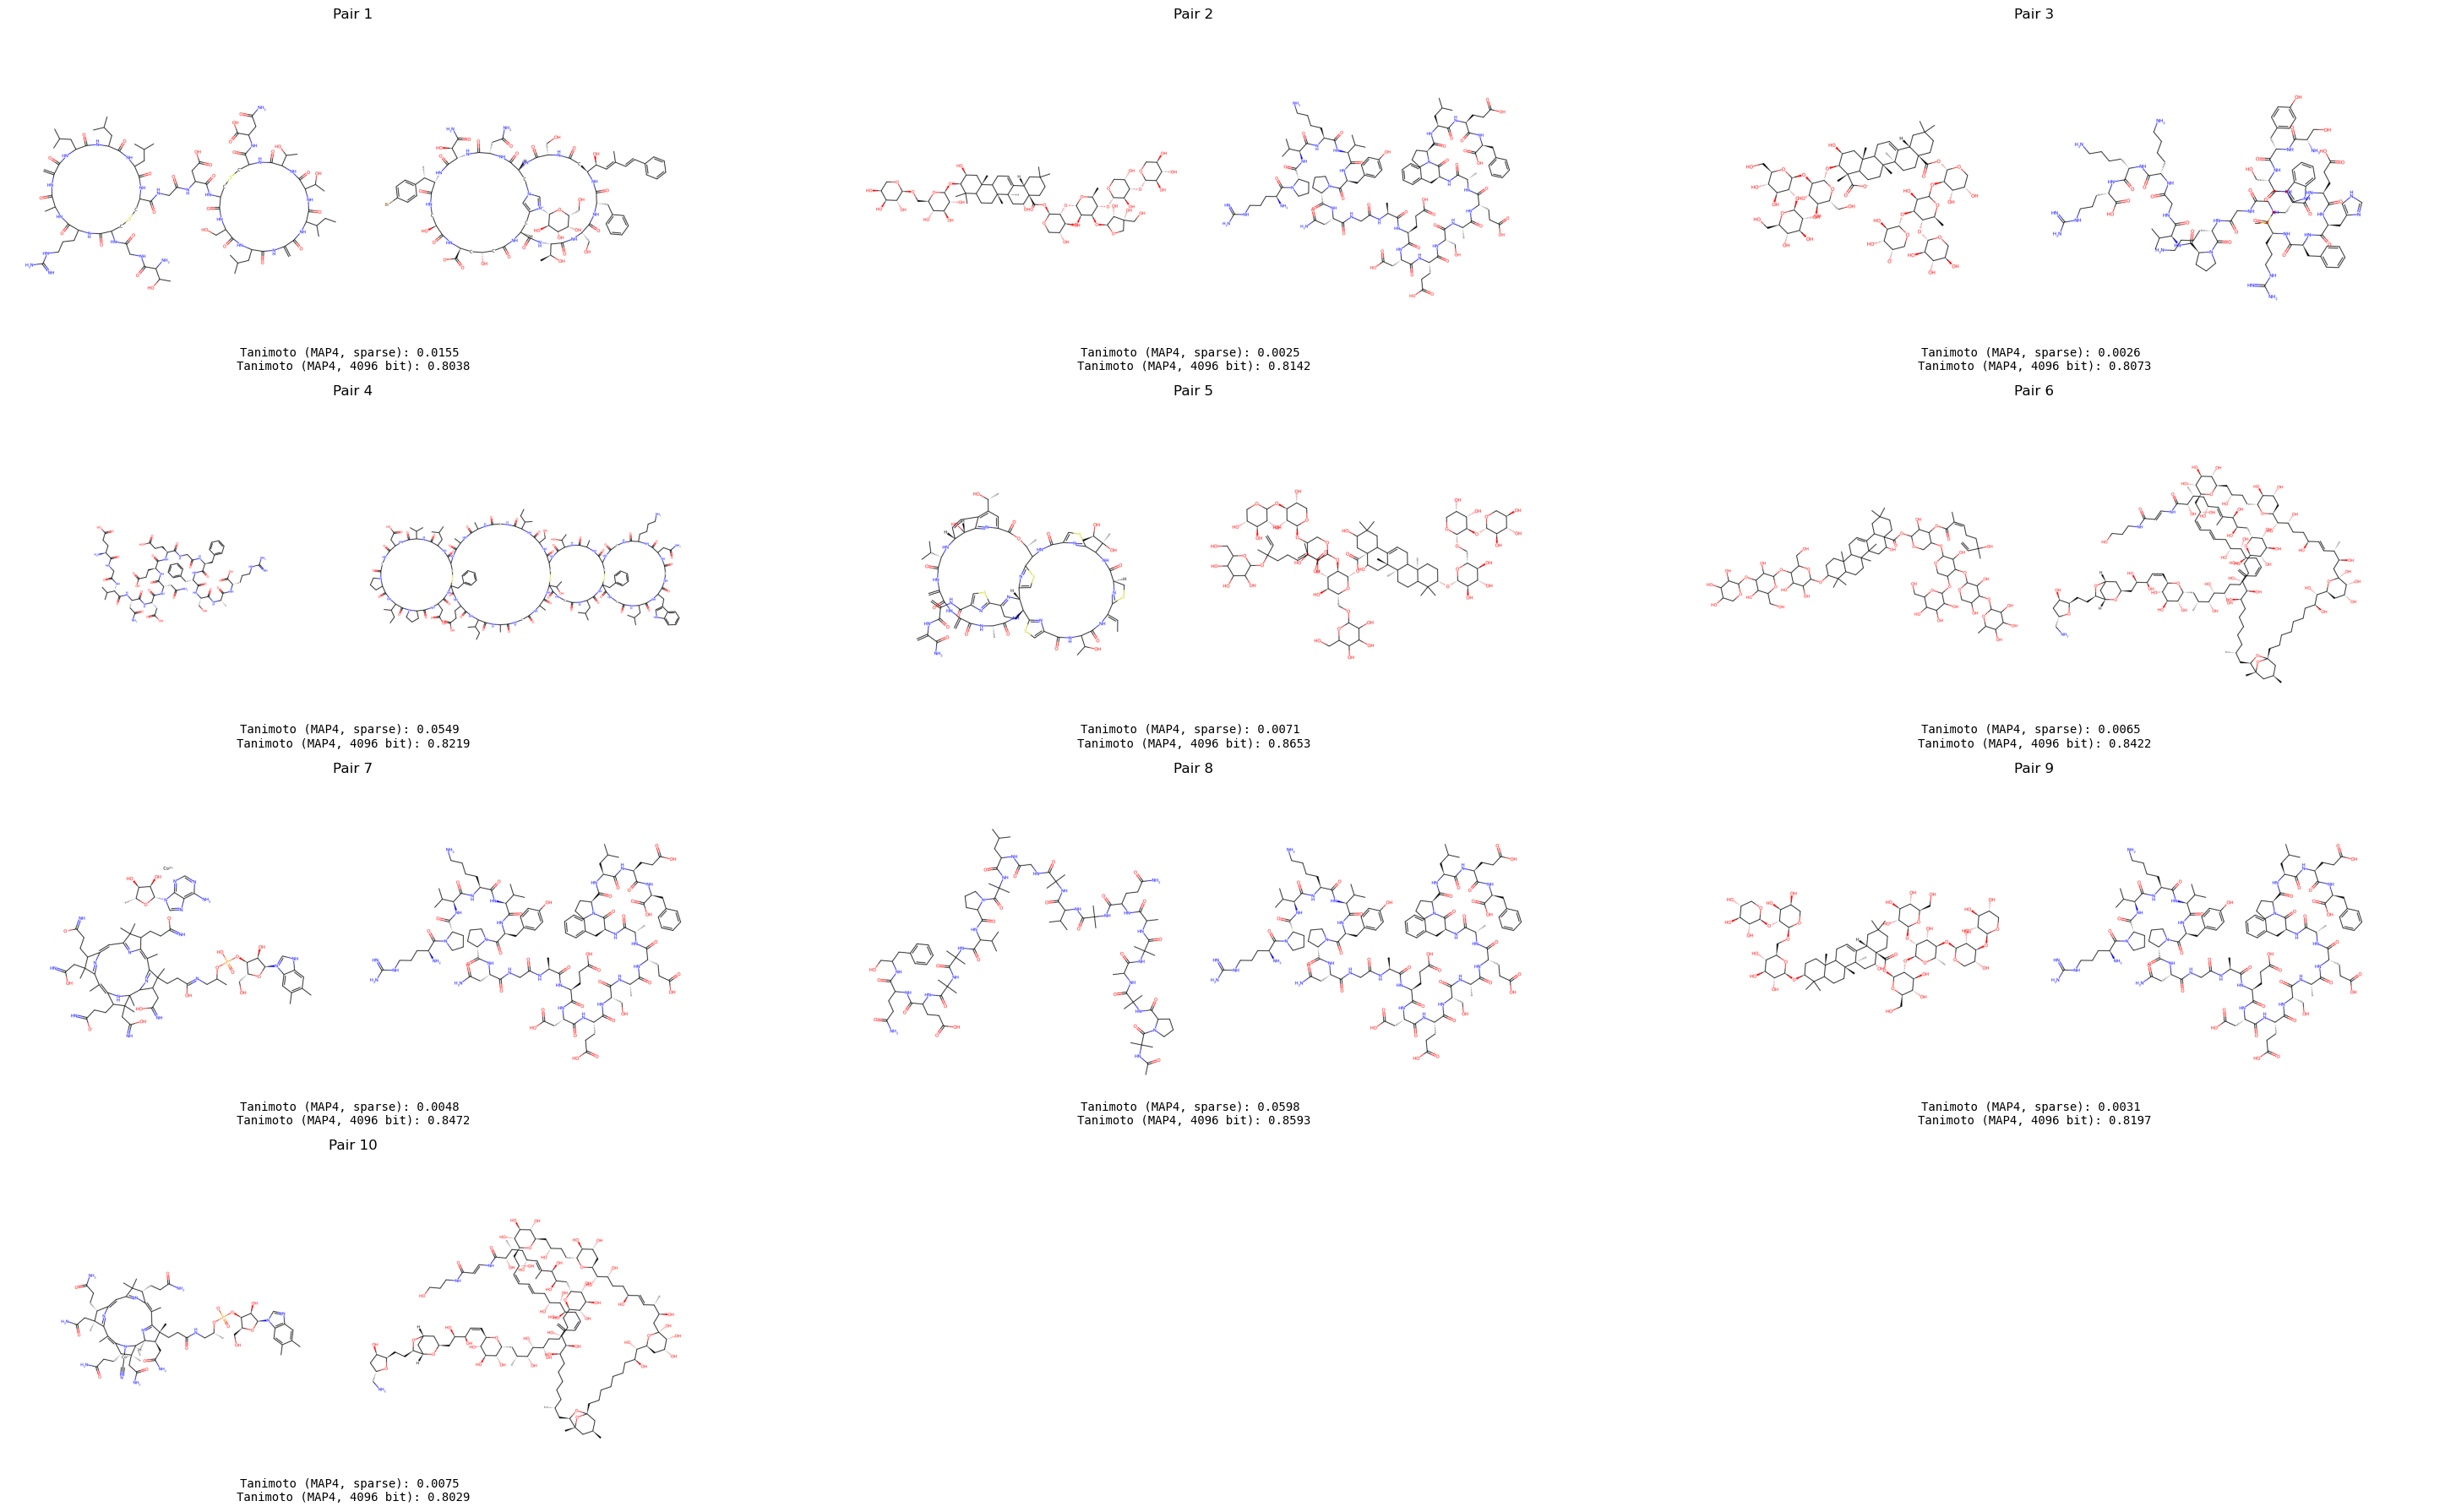

In [83]:
show_pairs_in_grid(
    select_pairs_from_ids(idx, 10), 3,
    filename="examples_map4_vs_sparse_01.png",
    dpi=450
    )